<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Adapted-from:--http://www.bioconductor.org/help/workflows/rnaseqGene/" data-toc-modified-id="Adapted-from:--http://www.bioconductor.org/help/workflows/rnaseqGene/-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Adapted from:  <a href="http://www.bioconductor.org/help/workflows/rnaseqGene/" target="_blank">http://www.bioconductor.org/help/workflows/rnaseqGene/</a></a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Create-DESeq-Data-Set" data-toc-modified-id="Create-DESeq-Data-Set-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create DESeq Data Set</a></span></li><li><span><a href="#Calculate-TPM" data-toc-modified-id="Calculate-TPM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate TPM</a></span></li><li><span><a href="#PCA-and-clustering" data-toc-modified-id="PCA-and-clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PCA and clustering</a></span><ul class="toc-item"><li><span><a href="#PCA" data-toc-modified-id="PCA-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li><li><span><a href="#Find-DEGs" data-toc-modified-id="Find-DEGs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Find DEGs</a></span></li></ul></div>

# Adapted from:  http://www.bioconductor.org/help/workflows/rnaseqGene/

To learn basics of R: https://www.datacamp.com/courses/free-introduction-to-r

# Setup

In [1]:
suppressPackageStartupMessages(library('SummarizedExperiment'))
suppressPackageStartupMessages(library('GenomicFeatures'))
suppressPackageStartupMessages(library('DESeq2'))

# Create DESeq Data Set

In [2]:
load('example/se.rda')

Create the DESeqDataSet, and designate the experimental design. The experimental design can include information from the colData. Use ~1 to ignore design criteria.

In [3]:
colnames(se)

[1] "wt_fe2_1"     "wt_fe2_2"     "wt_dpd_1"     "wt_dpd_2"     "delfur_fe2_1"
[6] "delfur_fe2_2" "delfur_dpd_1" "delfur_dpd_2"

In [4]:
# Designate groups for comparisons by removing the replicate subscript from colnames
colData(se)$group <- gsub('.{2}$', '', colnames(se))
colData(se)$group

[1] "wt_fe2"     "wt_fe2"     "wt_dpd"     "wt_dpd"     "delfur_fe2"
[6] "delfur_fe2" "delfur_dpd" "delfur_dpd"

In [5]:
dds <- DESeqDataSet(se, design = ~group)

Warning message in DESeqDataSet(se, design = ~group):
“some variables in design formula are characters, converting to factors”

Remove genes that have 0 counts across experimental conditions

In [6]:
nrow(dds)
dds <- dds[rowSums(assay(dds)) > 0, ]
nrow(dds)

[1] 4386

[1] 4296

In [7]:
head(assay(dds))

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,218,294,29,29,316,367,27,21
b0002,3382,2782,5099,5787,3607,3763,1579,1876
b0003,1027,901,1411,1945,1061,1028,450,642
b0004,1062,977,1038,1366,929,920,326,420
b0005,45,34,18,24,30,25,11,10
b0006,58,53,63,78,64,52,57,63


# Calculate TPM

In [8]:
fpkm_data <- fpkm(dds)
head(fpkm_data)

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,4803.8413,6446.7638,572.72061,572.0612,6550.3662,7589.69845,525.80367,411.34454
b0002,2026.4685,1658.7680,2738.19219,3104.0741,2033.1000,2116.05414,836.13438,999.20220
b0003,1623.4187,1417.2522,1998.93999,2752.2763,1577.6905,1525.03390,628.63751,902.08903
b0004,1217.3504,1114.4175,1066.35328,1401.6970,1001.7357,989.70377,330.24511,427.95162
b0005,222.9478,167.6223,79.92375,106.4423,139.8165,116.24038,48.16273,44.03976
b0006,110.0666,100.0842,107.14714,132.5056,114.2493,92.60981,95.59384,106.27282


In [9]:
tpm_data <- sweep(fpkm_data,2,colSums(fpkm_data),`/`)*1e6 # Divide each column by the column sum (times 1e6)
head(tpm_data)

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,3568.40476,4769.24885,509.62495,515.87170,5382.89109,6229.76308,460.57682,365.90250
b0002,1505.30782,1227.13934,2436.53016,2799.18299,1670.73955,1736.89588,732.41047,888.81835
b0003,1205.91303,1048.46846,1778.72014,2481.93979,1296.49791,1251.77567,550.65395,802.43347
b0004,904.27614,824.43450,948.87493,1264.01826,823.19583,812.36693,289.27763,380.67496
b0005,165.61081,124.00526,71.11869,95.98724,114.89690,95.41222,42.18806,39.17460
b0006,81.75999,74.04125,95.34292,119.49054,93.88662,76.01583,83.73526,94.53265


In [11]:
write.csv(tpm_data, file = "example/deseq2-tpm.csv")

# PCA and clustering

Raw counts from RNAseq tend to be exponentially distributed, so a log transform must be applied before running linear methods such as PCA or clustering. Since some counts can be 0, we must apply log(x + 1) to avoid infinite values. However, due to technical reasons, genes with lower counts have higher variance than genes with higher counts. PCA works best with constant variance, so to fix this DESeq2 has a model-based regularized log transform (rlog) to normalize the variance. The rlog counts are only used for this QC step, and should not be used for finding DEGs or other statistical tests.

In [12]:
rld <- rlog(dds)

In [13]:
library("pheatmap")
library("RColorBrewer")

## PCA

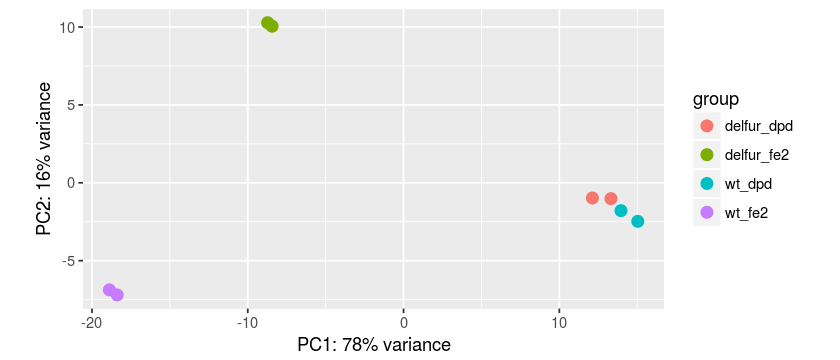

In [14]:
options(repr.plot.width=7, repr.plot.height=3)
plotPCA(rld,intgroup=c('group'))

## Clustering

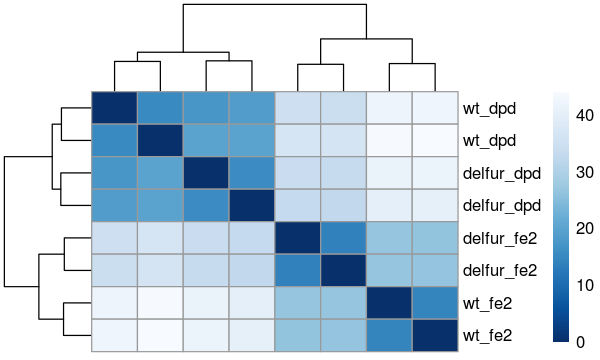

In [15]:
options(repr.plot.width=5, repr.plot.height=3)
# Generate (euclidean) distance matrix
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix( sampleDists )
# Designate the names for the rows
rownames(sampleDistMatrix) <- colData(rld)$group
# Designate the names for the columns
colnames(sampleDistMatrix) <- NULL
# Choose color palette
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
# Create heatmap
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

# Find DEGs

In [16]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Designate which groups you want to compare for DEGs.

In [17]:
res_FeCl2 <- results(dds,contrast = c('group','delfur_fe2','wt_fe2'))
res_DPD <- results(dds,contrast = c('group','delfur_dpd','wt_dpd'))

Put results into table form. Log2foldchange is positive if the first group (e.g. delfur_fe2) is larger than the second (e.g. wt_fe2)

In [18]:
resTable_FeCl2 <- data.frame(res_FeCl2@listData,row.names = res_FeCl2@rownames)
resTable_DPD <- data.frame(res_DPD@listData,row.names = res_DPD@rownames)

In [19]:
head(resTable_FeCl2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b0001,165.69371,0.32595929,0.2144027,1.52031352,0.1284322,0.5899230
b0002,3440.64426,0.16992545,0.1438663,1.18113420,0.2375494,0.7858632
b0003,1044.68785,0.02884104,0.1841897,0.15658332,0.8755733,0.9950179
b0004,875.31200,-0.22557046,0.1664815,-1.35492824,0.1754404,0.6947670
b0005,24.81883,-0.57606885,0.4238237,-1.35921804,0.1740775,0.6933004
b0006,60.12654,-0.02207137,0.3086625,-0.07150649,0.9429947,0.9950179


In [20]:
deg_FeCl2 <- resTable_FeCl2[complete.cases(resTable_FeCl2[,c('padj','log2FoldChange')]) & 
                            # ^ Make sure that LogFoldChange and p-adjusted are complete (not null)
                            resTable_FeCl2$padj < .05 & # Adjusted p-value cutoff of 0.05
                            abs(resTable_FeCl2$log2FoldChange) > 1,] # abs(log2foldChange) cutoff of 1

deg_DPD <- resTable_DPD[complete.cases(resTable_DPD[,c('padj','log2FoldChange')]) & 
                        # ^ Make sure that LogFoldChange and p-adjusted are complete (not null)
                        resTable_DPD$padj < .05 & # Adjusted p-value cutoff of 0.05
                        abs(resTable_DPD$log2FoldChange) > 1,] # abs(log2foldChange) cutoff of 1

In [21]:
head(deg_FeCl2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b0118,2257.10621,-1.272365,0.1225904,-10.378994,3.090144e-25,2.608964e-23
b0123,307.93132,-2.021256,0.1816753,-11.125652,9.411517e-29,9.815659e-27
b0150,668.05446,1.041516,0.1798305,5.791657,6.969531e-09,2.287878e-07
b0152,41.37777,1.207062,0.3965876,3.043619,2.337510e-03,2.800273e-02
b0272,53.15386,-1.000125,0.3194939,-3.130341,1.746037e-03,2.172438e-02
b0273,319.80446,-1.128928,0.2117670,-5.330993,9.767732e-08,2.727274e-06
